# [**Tracé des courbes d'apprentissage et vérification de la scalabilité des modèles**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/3_model_selection/plot_learning_curve.ipynb)<br/>([_Plotting Learning Curves and Checking Models’ Scalability_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html))

Dans cet exemple, nous montrons comment utiliser la classe [**`LearningCurveDisplay`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html) pour tracer facilement des courbes d'apprentissage. De plus, nous interprétons les courbes d'apprentissage obtenues pour un classificateur Naive Bayes et un classifieur SVM.

Ensuite, nous explorons et tirons des conclusions sur la scalabilité de ces modèles prédictifs en examinant leur coût de calcul et pas seulement leur précision statistique.

# Courbe d'apprentissage

Les courbes d'apprentissage montrent l'effet de l'ajout de plus d'échantillons pendant le processus d'entraînement. L'effet est représenté en vérifiant les performances statistiques du modèle en termes de score d'entraînement et de score de test.

Ici, nous calculons la courbe d'apprentissage d'un classificateur Naive Bayes et d'un classifieur SVM avec un noyau RBF en utilisant le jeu de données "digits".

In [1]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", gamma=0.001)

La méthode [**`from_estimator`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html#sklearn.model_selection.LearningCurveDisplay.from_estimator) affiche la courbe d'apprentissage en fonction du jeu de données et du modèle prédictif à analyser. Pour obtenir une estimation de l'incertitude des scores, cette méthode utilise une procédure de validation croisée.

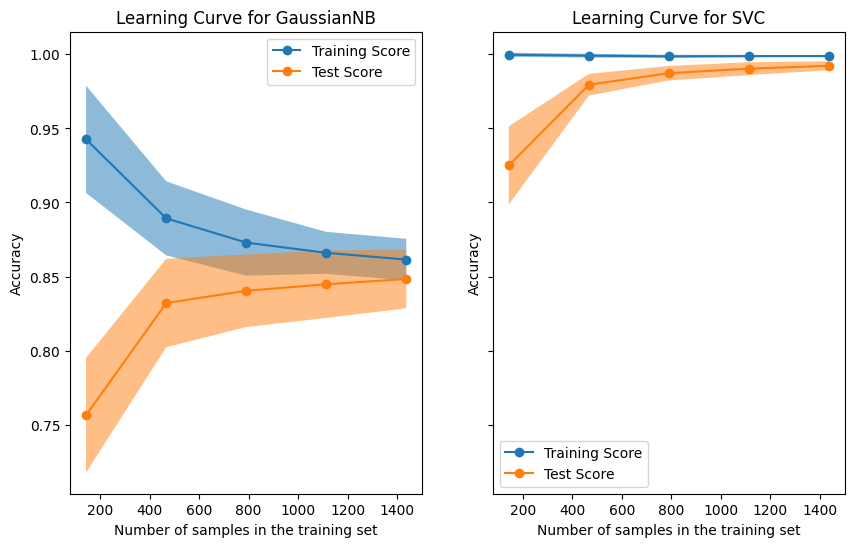

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

Nous analysons d'abord la courbe d'apprentissage du classifieur Naive Bayes. Sa forme est souvent trouvée dans des jeux de données plus complexes : le score d'entraînement est très élevé lorsqu'on utilise peu d'échantillons pour l'entraînement et diminue lorsque le nombre d'échantillons augmente, tandis que le score de test est très faible au début et augmente ensuite avec l'ajout d'échantillons. Les scores d'entraînement et de test deviennent plus réalistes lorsque tous les échantillons sont utilisés pour l'entraînement.

Nous voyons une autre courbe d'apprentissage typique pour le classifieur SVM avec noyau RBF. Le score d'entraînement reste élevé quel que soit la taille de l'ensemble d'entraînement. En revanche, le score de test augmente avec la taille de l'ensemble d'entraînement. En effet, il augmente jusqu'à un point où il atteint un plateau. Observer un tel plateau indique qu'il pourrait ne pas être utile d'acquérir de nouvelles données pour entraîner le modèle, car la performance de généralisation du modèle n'augmentera plus.

# Analyse de la complexité

En plus de ces courbes d'apprentissage, il est également possible d'examiner la scalabilité des modèles prédictifs en termes de temps d'entraînement et de score.

La classe [**`LearningCurveDisplay`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html) ne fournit pas de telles informations. Nous devons donc nous tourner vers la fonction [**`learning_curve`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) et créer le graphique manuellement.

In [3]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "n_jobs": 4,
    "return_times": True,
}

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    naive_bayes, **common_params
)
train_sizes, _, test_scores_svm, fit_times_svm, score_times_svm = learning_curve(
    svc, **common_params
)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=True)

for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_svm],
        [score_times_nb, score_times_svm],
        [naive_bayes, svc],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(
        f"Scalability of the {estimator.__class__.__name__} classifier"
    )

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

Nous voyons que la scalabilité des classifieurs SVM et Naive Bayes est très différente. La complexité du classifieur SVM en termes de temps d'ajustement et de score augmente rapidement avec le nombre d'échantillons. En effet, on sait que la complexité temporelle de l'ajustement de ce classifieur est supérieure à quadratique par rapport au nombre d'échantillons, ce qui rend difficile l'évolutivité vers des ensembles de données de plus de quelques 10 000 échantillons. En revanche, le classifieur Naive Bayes s'échelonne beaucoup mieux avec une complexité moindre en termes de temps d'ajustement et de score.

Ensuite, nous pouvons vérifier le compromis entre le temps d'entraînement accru et le score de validation croisée.

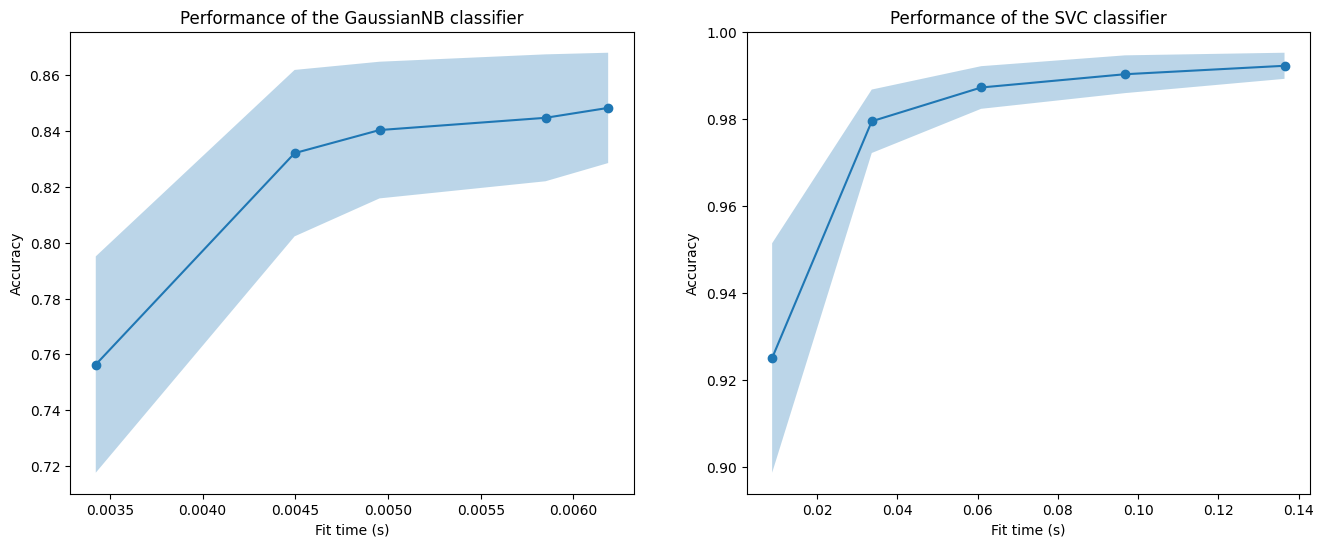

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_svm],
        [test_scores_nb, test_scores_svm],
        [naive_bayes, svc],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("Accuracy")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(
        f"Performance of the {estimator.__class__.__name__} classifier"
    )

plt.show()

Dans ces graphiques, nous pouvons rechercher le point d'inflexion pour lequel le score de validation croisée n'augmente plus et seul le temps d'entraînement augmente.